In [0]:
# implementation of https://github.com/soumik12345/Enet
# https://arxiv.org/abs/1606.02147

# adapted from
# https://github.com/iArunava/ENet-Real-Time-Semantic-Segmentation/blob/master/ENet-Real%20Time%20Semantic%20Segmentation.ipynb

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from tqdm import tqdm
from PIL import Image

In [0]:
class InitialBlock(nn.Module):
    def __init__(self):
        super(InitialBlock, self).__init__()
        # 3x3 conv, s=2, p=1 -> 13 x H/2 x W/2
        self.conv = nn.Sequential(
            nn.Conv2d(3, 13, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(13),
            nn.PReLU(13),
        )

        # 3 x H/2 x W/2
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x_1 = self.conv(x)
        x_2 = self.pool(x)
        out = torch.cat([x_1, x_2], dim=1)

        return out


# extension: 2x2 conv with s=2 -> 3x3 conv -> 1x1 expansion -> dropout
# main: maxpool -> padding
# prelu(extension + main) -> out = out_C, in_H/2, in_W/2
class DownsampleBN(nn.Module):
    def __init__(self, in_channels, out_channels, p_drop, projection_ratio=4):
        super(DownsampleBN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.reduced_channels = in_channels // projection_ratio  # apply dimension reducing projection

        self.extension = nn.Sequential(
            # if the bottleneck is downsampling, the first 1x1 projection is replaced with a 2x2 conv with stride 2
            nn.Conv2d(in_channels, self.reduced_channels, kernel_size=2, stride=2),  # C/proj_ratio, H/2, W/2
            nn.BatchNorm2d(self.reduced_channels),
            nn.PReLU(self.reduced_channels),
            # 3x3 conv
            nn.Conv2d(self.reduced_channels, self.reduced_channels, kernel_size=3, padding=1),  # pad by 1 to conserve H & W
            nn.BatchNorm2d(self.reduced_channels),
            nn.PReLU(self.reduced_channels),
            # 1x1 expansion: out_channels = in_channels x (2 or 4) = reduced_channels x projection_ratio x (2 or 4)
            nn.Conv2d(self.reduced_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            # p_drop=0.01 before bn2_0, =0.1 after
            nn.Dropout2d(p=p_drop),
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.prelu = nn.PReLU()

    def forward(self, x):
        batch_size = x.size(0)
        x_copy = x

        # extension: Cx(2 or 4), H/2, W/2
        x_copy = self.extension(x_copy)

        # main branch
        x, indices = self.pool(x)  # C, H/2, W/2
        channel_diff = self.out_channels - self.in_channels
        zero_padding = torch.zeros((batch_size, channel_diff, x.size(2), x.size(3)))
        if torch.cuda.is_available():
            zero_padding = zero_padding.cuda()
            
        x = torch.cat([x, zero_padding], dim=1)  # concat pooled x and zero paddings to make channel dims = out_channels
        
        # element-wise add main and extension and apply PReLU
        out = x + x_copy
        out = self.prelu(out)

        return out, indices


# extension: 1x1 proj -> 3x3 conv -> 1x1 expansion -> dropout
# main: skip
# prelu(extension + main) -> out = in_C, in_H, in_W
class RegularBN(nn.Module):
    def __init__(self, in_channels, p_drop, projection_ratio=4):
        super(RegularBN, self).__init__()
        out_channels = in_channels  # out_C is the same as in_C
        self.reduced_channels = in_channels // projection_ratio  # apply dimension reducing projection

        self.extension = nn.Sequential(
            # 1x1 projection to reduce dims (no bias)
            nn.Conv2d(in_channels, self.reduced_channels, kernel_size=1, bias=False),  # C/proj_ratio, H, W
            nn.BatchNorm2d(self.reduced_channels),
            nn.PReLU(self.reduced_channels),
            # 3x3 conv
            nn.Conv2d(self.reduced_channels, self.reduced_channels, kernel_size=3, padding=1),  # pad by 1 to conserve H & W
            nn.BatchNorm2d(self.reduced_channels),
            nn.PReLU(self.reduced_channels),
            # 1x1 expansion: out_channels = in_channels = reduced_channels x projection_ratio
            nn.Conv2d(self.reduced_channels, out_channels, kernel_size=1),  # C x proj_ratio, H, W
            nn.BatchNorm2d(out_channels),
            # p_drop=0.01 before bn2_0, =0.1 after
            nn.Dropout2d(p=p_drop),
        )

        self.prelu = nn.PReLU()

    def forward(self, x):
        x_copy = x

        # extension: C, H, W
        x_copy = self.extension(x_copy)

        # nothing in main branch
        # element-wise add main and extension and apply PReLU
        out = x + x_copy
        out = self.prelu(out)

        return out


# extension: 1x1 proj -> 3x3 conv (dilated) -> 1x1 expansion -> dropout
# main: skip
# prelu(extension + main) -> out = in_C, in_H, in_W
class DilatedBN(nn.Module):
    def __init__(self, in_channels, dilation, p_drop, projection_ratio=4):
        super(DilatedBN, self).__init__()
        out_channels = in_channels  # out_C is the same as in_C
        self.reduced_channels = in_channels // projection_ratio  # apply dimension reducing projection

        self.extension = nn.Sequential(
            # 1x1 projection to reduce dims (no bias)
            nn.Conv2d(in_channels, self.reduced_channels, kernel_size=1, bias=False),  # C/proj_ratio, H, W
            nn.BatchNorm2d(self.reduced_channels),
            nn.PReLU(self.reduced_channels),
            # 3x3 conv (dilated)
            nn.Conv2d(self.reduced_channels, self.reduced_channels, kernel_size=3, padding=dilation, dilation=dilation),  # p=dilation to conserve H & W
            nn.BatchNorm2d(self.reduced_channels),
            nn.PReLU(self.reduced_channels),
            # 1x1 expansion: out_channels = in_channels = reduced_channels x projection_ratio
            nn.Conv2d(self.reduced_channels, out_channels, kernel_size=1),  # C x proj_ratio, H, W
            nn.BatchNorm2d(out_channels),
            # p_drop=0.01 before bn2_0, =0.1 after
            nn.Dropout2d(p=p_drop),
        )

        self.prelu = nn.PReLU()

    def forward(self, x):
        x_copy = x

        # extension: C, H, W
        x_copy = self.extension(x_copy)

        # nothing in main branch
        # element-wise add main and extension and apply PReLU
        out = x + x_copy
        out = self.prelu(out)

        return out


# extension: 1x1 proj -> 5x5 decomposed conv (2 asymmetric convs) -> 1x1 expansion -> dropout
# main: skip
# prelu(extension + main) -> out = in_C, in_H, in_W
class AsymmetricBN(nn.Module):
    def __init__(self, in_channels, p_drop, projection_ratio=4):
        super(AsymmetricBN, self).__init__()
        out_channels = in_channels  # out_C is the same as in_C
        self.reduced_channels = in_channels // projection_ratio  # apply dimension reducing projection

        self.extension = nn.Sequential(
            # 1x1 projection to reduce dims (no bias)
            nn.Conv2d(in_channels, self.reduced_channels, kernel_size=1, bias=False),  # C/proj_ratio, H, W
            nn.BatchNorm2d(self.reduced_channels),
            nn.PReLU(self.reduced_channels),
            # 5x1 conv + 1x5 conv = 5x5 decomposed conv
            nn.Conv2d(self.reduced_channels, self.reduced_channels, kernel_size=(5, 1), padding=(2, 0)),  # pad by (2, 0) to conserve H & W
            nn.Conv2d(self.reduced_channels, self.reduced_channels, kernel_size=(1, 5), padding=(0, 2)),  # pad by (0, 2) to conserve H & W
            nn.BatchNorm2d(self.reduced_channels),
            nn.PReLU(self.reduced_channels),
            # 1x1 expansion: out_channels = in_channels = reduced_channels x projection_ratio
            nn.Conv2d(self.reduced_channels, out_channels, kernel_size=1),  # C x proj_ratio, W, H
            nn.BatchNorm2d(out_channels),
            # p_drop=0.01 before bn2_0, =0.1 after
            nn.Dropout2d(p=p_drop),
        )

        self.prelu = nn.PReLU()

    def forward(self, x):
        x_copy = x

        # extension: C, W, H
        x_copy = self.extension(x_copy)

        # nothing in main branch
        # element-wise add main and extension and apply PReLU
        out = x + x_copy
        out = self.prelu(out)

        return out


# extension: 1x1 proj -> 3x3 deconv -> 1x1 expansion -> dropout
# main: maxunpool -> 1x1 conv (no bias)
# prelu(extension + main) -> out = out_C, in_H x 2, in_W x 2
class UpsampleBN(nn.Module):
    def __init__(self, in_channels, out_channels, p_drop, projection_ratio=4):
        super(UpsampleBN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.reduced_channels = in_channels // projection_ratio  # apply dimension reducing projection

        self.extension = nn.Sequential(
            # 1x1 projection to reduce dims (no bias)
            nn.Conv2d(in_channels, self.reduced_channels, kernel_size=1, bias=False),  # C/proj_ratio, H, W
            nn.BatchNorm2d(self.reduced_channels),
            nn.PReLU(self.reduced_channels),
            # 3x3 conv
            nn.ConvTranspose2d(self.reduced_channels, self.reduced_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # pad by 1 to conserve H & W
            nn.BatchNorm2d(self.reduced_channels),
            nn.PReLU(self.reduced_channels),
            # 1x1 expansion: out_channels = in_channels/(2 or 4)
            nn.Conv2d(self.reduced_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            # p_drop=0.01 before bn2_0, =0.1 after
            nn.Dropout2d(p=p_drop),
        )

        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.main_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.main_conv
        self.prelu = nn.PReLU()

    def forward(self, x, indices):
        x_copy = x

        # extension: C/(2 or 4), H x 2, W x 2
        x_copy = self.extension(x_copy)

        # main branch
        x = self.main_conv(x)  # C/(2 or 4), H, W
        x = self.unpool(x, indices)  # C, H x 2, W x 2
        # x = self.main_conv(x)  # C/(2 or 4), H, W
        
        # element-wise add main and extension and apply PReLU
        out = x + x_copy
        out = self.prelu(out)

        return out


class ENet(nn.Module):
    def __init__(self, C):
        super(ENet, self).__init__()

        # initial block
        self.initial = InitialBlock()
        
        # encode - stage 1
        self.bn1_0 = DownsampleBN(16, 64, p_drop=0.01)
        self.bn1_1 = RegularBN(64, p_drop=0.01)
        self.bn1_2 = RegularBN(64, p_drop=0.01)
        self.bn1_3 = RegularBN(64, p_drop=0.01)
        self.bn1_4 = RegularBN(64, p_drop=0.01)

        # encode - stage 2
        self.bn2_0 = DownsampleBN(64, 128, p_drop=0.1)
        self.bn2_1 = RegularBN(128, p_drop=0.1)
        self.bn2_2 = DilatedBN(128, dilation=2, p_drop=0.1)
        self.bn2_3 = AsymmetricBN(128, p_drop=0.1)
        self.bn2_4 = DilatedBN(128, dilation=4, p_drop=0.1)
        self.bn2_5 = RegularBN(128, p_drop=0.1)
        self.bn2_6 = DilatedBN(128, dilation=8, p_drop=0.1)
        self.bn2_7 = AsymmetricBN(128, p_drop=0.1)
        self.bn2_8 = DilatedBN(128, dilation=16, p_drop=0.1)

        # encode - stage 3 (same as stage 2 but w/o downsampling)
        self.bn3_1 = RegularBN(128, p_drop=0.1)
        self.bn3_2 = DilatedBN(128, dilation=2, p_drop=0.1)
        self.bn3_3 = AsymmetricBN(128, p_drop=0.1)
        self.bn3_4 = DilatedBN(128, dilation=4, p_drop=0.1)
        self.bn3_5 = RegularBN(128, p_drop=0.1)
        self.bn3_6 = DilatedBN(128, dilation=8, p_drop=0.1)
        self.bn3_7 = AsymmetricBN(128, p_drop=0.1)
        self.bn3_8 = DilatedBN(128, dilation=16, p_drop=0.1)

        # decode - stage 4
        self.bn4_0 = UpsampleBN(128, 64, p_drop=0.1)
        self.bn4_1 = RegularBN(64, p_drop=0.1)
        self.bn4_2 = RegularBN(64, p_drop=0.1)

        # decode - stage 5
        self.bn5_0 = UpsampleBN(64, 16, p_drop=0.1)
        self.bn5_1 = RegularBN(16, p_drop=0.1)

        # last fullconv
        self.fullconv = nn.ConvTranspose2d(16, C, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        # initial block
        x = self.initial(x)

        # encode - stage 1
        x, i1 = self.bn1_0(x)
        x = self.bn1_1(x)
        x = self.bn1_2(x)
        x = self.bn1_3(x)
        x = self.bn1_4(x)

        # encode - stage 2
        x, i2 = self.bn2_0(x)
        x = self.bn2_1(x)
        x = self.bn2_2(x)
        x = self.bn2_3(x)
        x = self.bn2_4(x)
        x = self.bn2_5(x)
        x = self.bn2_6(x)
        x = self.bn2_7(x)
        x = self.bn2_8(x)

        # encode - stage 3
        x = self.bn3_1(x)
        x = self.bn3_2(x)
        x = self.bn3_3(x)
        x = self.bn3_4(x)
        x = self.bn3_5(x)
        x = self.bn3_6(x)
        x = self.bn3_7(x)
        x = self.bn3_8(x)

        # decode - stage 4
        x = self.bn4_0(x, i2)
        x = self.bn4_1(x)
        x = self.bn4_2(x)

        # decode - stage 5
        x = self.bn5_0(x, i1)
        x = self.bn5_1(x)

        # last fullconv
        out = self.fullconv(x)

        return out

In [0]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
enet = ENet(1).to(device)
summary(enet, (3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 13, 256, 256]             364
       BatchNorm2d-2         [-1, 13, 256, 256]              26
             PReLU-3         [-1, 13, 256, 256]              13
         MaxPool2d-4          [-1, 3, 256, 256]               0
      InitialBlock-5         [-1, 16, 256, 256]               0
            Conv2d-6          [-1, 4, 128, 128]             260
       BatchNorm2d-7          [-1, 4, 128, 128]               8
             PReLU-8          [-1, 4, 128, 128]               4
            Conv2d-9          [-1, 4, 128, 128]             148
      BatchNorm2d-10          [-1, 4, 128, 128]               8
            PReLU-11          [-1, 4, 128, 128]               4
           Conv2d-12         [-1, 64, 128, 128]             320
      BatchNorm2d-13         [-1, 64, 128, 128]             128
        Dropout2d-14         [-1, 64, 1

In [0]:
!wget https://www.dropbox.com/s/pxcz2wdz04zxocq/CamVid.zip?dl=1 -O CamVid.zip
!unzip CamVid.zip

--2020-02-25 17:27:47--  https://www.dropbox.com/s/pxcz2wdz04zxocq/CamVid.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/pxcz2wdz04zxocq/CamVid.zip [following]
--2020-02-25 17:27:52--  https://www.dropbox.com/s/dl/pxcz2wdz04zxocq/CamVid.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2d92d08b63aa6037f9c43bc2b1.dl.dropboxusercontent.com/cd/0/get/Aywch56w4CRvpkU2Mc9Lj9BLOU_Dch0UH1MhHlz4fHvw9XUqK8-43MKoCt7nvhxd28ro7KL9BlhZkM4R6EADl3IIgSMJq6KuaLZZecZTv-0mtA/file?dl=1# [following]
--2020-02-25 17:27:53--  https://uc2d92d08b63aa6037f9c43bc2b1.dl.dropboxusercontent.com/cd/0/get/Aywch56w4CRvpkU2Mc9Lj9BLOU_Dch0UH1MhHlz4fHvw9XUqK8-43MKoCt7nvhxd28ro7KL9BlhZkM4R6EADl3IIgSMJq6KuaLZZecZTv-0mtA/file?dl=1
Resolving uc2d9

In [0]:
enet = ENet(12)

# Checking if there is any gpu available and pass the model to gpu or cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
enet = enet.to(device)

In [0]:
def loader(training_path, segmented_path, batch_size, h=320, w=1000):
    filenames_t = os.listdir(training_path)
    total_files_t = len(filenames_t)
    
    filenames_s = os.listdir(segmented_path)
    total_files_s = len(filenames_s)
    
    assert(total_files_t == total_files_s)
    
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    
    idx = 0
    while(1):
      # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
            
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
          # Reading normalized photo
            img = plt.imread(training_path + filenames_t[jj])
          # Resizing using nearest neighbor method
            img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            inputs.append(img)
          
          # Reading semantic image
            img = Image.open(segmented_path + filenames_s[jj])
            img = np.array(img)
          # Resizing using nearest neighbor method
            img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            labels.append(img)
         
        inputs = np.stack(inputs, axis=2)
      # Changing image format to C x H x W
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

In [0]:
def get_class_weights(num_classes, c=1.02):
    pipe = loader('/content/train/', '/content/trainannot/', batch_size='all')
    _, labels = next(pipe)
    all_labels = labels.flatten()
    each_class = np.bincount(all_labels, minlength=num_classes)
    prospensity_score = each_class / len(all_labels)
    class_weights = 1 / (np.log(c + prospensity_score))
    return class_weights

In [0]:
class_weights = get_class_weights(12)

In [0]:
lr = 5e-4
batch_size = 10

criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
optimizer = torch.optim.Adam(enet.parameters(), 
                             lr=lr,
                             weight_decay=2e-4)

print_every = 5
eval_every = 5

In [0]:
train_losses = []
eval_losses = []

bc_train = 367 // batch_size # mini_batch train
bc_eval = 101 // batch_size  # mini_batch validation

# Define pipeline objects
pipe = loader('/content/train/', '/content/trainannot/', batch_size)
eval_pipe = loader('/content/val/', '/content/valannot/', batch_size)

epochs = 100

# Train loop

for e in range(1, epochs+1):
    
    
    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)
    
    enet.train()
    
    for _ in tqdm(range(bc_train)):
        X_batch, mask_batch = next(pipe)
        
        # assign data to cpu/gpu
        X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

        optimizer.zero_grad()

        out = enet(X_batch.float())
        
        # loss calculation
        loss = criterion(out, mask_batch.long())
        # update weights
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        
    print ()
    train_losses.append(train_loss)
    
    if (e+1) % print_every == 0:
        print ('Epoch {}/{}...'.format(e, epochs),
                'Loss {:6f}'.format(train_loss))
    
    if e % eval_every == 0:
        with torch.no_grad():
            enet.eval()
            
            eval_loss = 0

            # Validation loop
            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)

                
                inputs, labels = inputs.to(device), labels.to(device)
                    
                
                out = enet(inputs)
                
                out = out.data.max(1)[1]
                
                eval_loss += (labels.long() - out.long()).sum()
                
            
            print ()
            print ('Loss {:6f}'.format(eval_loss))
            
            eval_losses.append(eval_loss)
        
    if e % print_every == 0:
        checkpoint = {
            'epochs' : e,
            'state_dict' : enet.state_dict()
        }
        torch.save(checkpoint, '/content/ckpt-enet-{}-{}.pth'.format(e, train_loss))
        print ('Model saved!')

print ('Epoch {}/{}...'.format(e, epochs),
       'Total Mean Loss: {:6f}'.format(sum(train_losses) / epochs))

  0%|          | 0/36 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 2 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 3 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 4 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 4/100... Loss 59.147964
--------------- Epoch 5 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -1630449.000000
Model saved!
--------------- Epoch 6 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 7 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 8 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 9 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 9/100... Loss 45.454542
--------------- Epoch 10 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -4851691.000000
Model saved!
--------------- Epoch 11 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 12 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 13 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 14 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 14/100... Loss 39.536556
--------------- Epoch 15 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -14769797.000000
Model saved!
--------------- Epoch 16 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 17 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 18 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 19 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 19/100... Loss 38.433531
--------------- Epoch 20 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -10772336.000000
Model saved!
--------------- Epoch 21 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 22 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 23 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 24 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 24/100... Loss 34.307345
--------------- Epoch 25 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -8947875.000000
Model saved!
--------------- Epoch 26 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 27 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 28 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 29 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 29/100... Loss 33.463226
--------------- Epoch 30 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -11189314.000000
Model saved!
--------------- Epoch 31 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 32 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 33 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 34 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 34/100... Loss 30.160433
--------------- Epoch 35 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -15381356.000000
Model saved!
--------------- Epoch 36 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 37 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 38 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 39 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 39/100... Loss 28.302334
--------------- Epoch 40 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -13924768.000000
Model saved!
--------------- Epoch 41 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 42 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 43 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 44 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 44/100... Loss 28.964683
--------------- Epoch 45 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -13027572.000000
Model saved!
--------------- Epoch 46 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 47 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 48 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 49 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 49/100... Loss 25.297964
--------------- Epoch 50 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -11858065.000000
Model saved!
--------------- Epoch 51 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 52 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 53 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 54 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 54/100... Loss 25.374923
--------------- Epoch 55 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -11635178.000000
Model saved!
--------------- Epoch 56 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 57 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 58 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 59 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 59/100... Loss 24.277119
--------------- Epoch 60 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -12375566.000000
Model saved!
--------------- Epoch 61 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 62 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 63 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


--------------- Epoch 64 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 64/100... Loss 23.829026
--------------- Epoch 65 ---------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]


Loss -13809057.000000
Model saved!
--------------- Epoch 66 ---------------


 17%|█▋        | 6/36 [00:05<00:25,  1.17it/s]


KeyboardInterrupt: ignored

In [0]:
# Load a pretrained model if needed
enet = ENet(12)
state_dict = torch.load('/content/ckpt-enet-65-23.049733519554138.pth')['state_dict']
enet.load_state_dict(state_dict)

<All keys matched successfully>

In [0]:
fname = 'Seq05VD_f05100.png'
tmg_ = plt.imread('/content/test/' + fname)
tmg_ = cv2.resize(tmg_, (512, 512), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2).to(device)

enet.to(device)
with torch.no_grad():
    out1 = enet(tmg.float()).squeeze(0)

In [0]:
smg_ = Image.open('/content/testannot/' + fname)
smg_ = cv2.resize(np.array(smg_), (512, 512), cv2.INTER_NEAREST)

In [0]:
out2 = out1.cpu().detach().numpy()

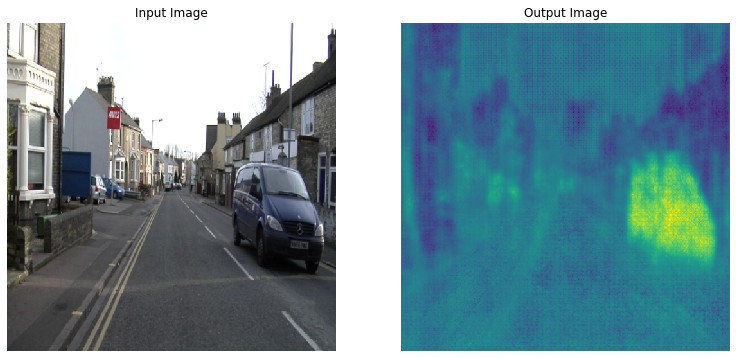

In [0]:
mno = 8 # Should be between 0 - n-1 | where n is the number of classes

figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Output Image')
plt.axis('off')
plt.imshow(out2[mno, :, :])
plt.show()

In [0]:
b_ = out1.data.max(0)[1].cpu().numpy()

In [0]:
def decode_segmap(image):
    Sky = [128, 128, 128]
    Building = [128, 0, 0]
    Pole = [192, 192, 128]
    Road_marking = [255, 69, 0]
    Road = [128, 64, 128]
    Pavement = [60, 40, 222]
    Tree = [128, 128, 0]
    SignSymbol = [192, 128, 128]
    Fence = [64, 64, 128]
    Car = [64, 0, 128]
    Pedestrian = [64, 64, 0]
    Bicyclist = [0, 128, 192]

    label_colours = np.array([Sky, Building, Pole, Road_marking, Road, 
                              Pavement, Tree, SignSymbol, Fence, Car, 
                              Pedestrian, Bicyclist]).astype(np.uint8)
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, 12):
        r[image == l] = label_colours[l, 0]
        g[image == l] = label_colours[l, 1]
        b[image == l] = label_colours[l, 2]

    rgb = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
    rgb[:, :, 0] = b
    rgb[:, :, 1] = g
    rgb[:, :, 2] = r
    return rgb

In [0]:
true_seg = decode_segmap(smg_)
pred_seg = decode_segmap(b_)

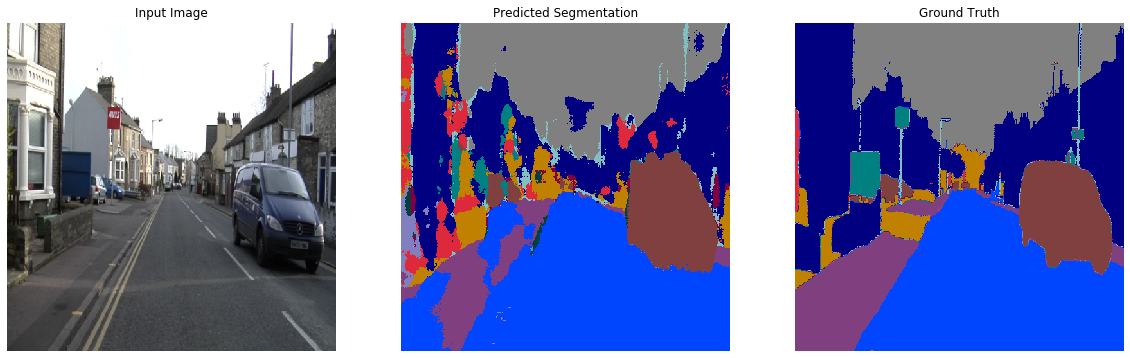

In [0]:
figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Predicted Segmentation')
plt.axis('off')
plt.imshow(pred_seg)
plt.subplot(1, 3, 3)
plt.title('Ground Truth')
plt.axis('off')
plt.imshow(true_seg)
plt.show()

In [0]:
# https://github.com/iArunava/ENet-Real-Time-Semantic-Segmentation/blob/master/ENet-Real%20Time%20Semantic%20Segmentation.ipynb
# https://github.com/soumik12345/Enet
# https://github.com/TimoSaemann/ENet
# https://colab.research.google.com/drive/1ncRxvmNR-iTtQCscj2UFSGV8ZQX_LN0M
# https://arxiv.org/pdf/1606.02147.pdf